#라이브러리 임포트

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#데이터 로드

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), #이미지를 tensor로 변환하며, 0~1로 자동 정규화
                                transforms.Normalize((0.5, ), (0.5, ))]) #흑백 채널의 평균과 표준편차를 각각 0.5로 두고 정규화 => 이미 0~1 범위를 가지므로 -1~1로 정규화

In [ ]:
trainset = datasets.FashionMNIST(root='/content',
                                 train = True, download = True, #train인지 test인지
                                 transform = transform) #transform 적용
testset = datasets.FashionMNIST(root='/content',
                                 train = False, download = True,
                                 transform = transform)

In [ ]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True) #trainset에서 셔플한 후 사이즈가 64인 배치들을 가져와줌
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
images, labels = next(iter(train_loader)) #train loader에서 이미지와 라벨을 쌍으로 하나씩 꺼내기

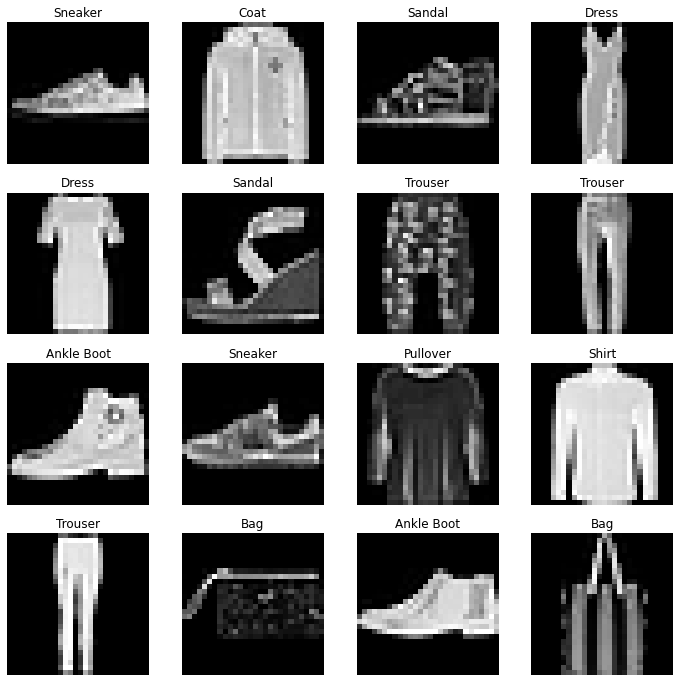

In [ ]:
import matplotlib.pyplot as plt

labels_map = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
  image = images[i].squeeze() #이미지
  label_idx = labels[i].item() #라벨
  label = labels_map[label_idx] #라벨명 테이블에서 해당하는 라벨 가져오기

  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(image, cmap = 'gray') #그림 그리기

plt.show()

In [ ]:
images[0].shape

torch.Size([1, 28, 28])

#모델 구현

In [ ]:
import torch.nn.functional as F

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3, 1) #인풋 채널의 수, 아웃풋 채널의 수(커널 개수), 커널 사이즈
                                    #스트라이드=1, 패딩=0, bias = true, 패딩모드 = 제로패딩
                                    #아웃풋 차원 = (인풋 차원 - 커널 사이즈 + 2 * 패딩사이즈)/스트라이드 + 1
                                    # = (28 - 3 + 2 * 0) / 1 + 1 = 26

    self.conv2 = nn.Conv2d(6, 16, 3)


    self.fc1 = nn.Linear(16 * 5 * 5, 120) #fc 레이어 시작: 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x) #(28 - 3 + 2 * 0)/1 + 1 = 26*26
    print(x.shape)
    x = F.relu(x) #26 * 26
    print(x.shape)
    x = F.max_pool2d(x, 2) #2*2 사이즈의 맥스풀링 레이어로 스트라이드 (기본값=커널사이즈)2씩 이동,  = 13 * 13 차원으로 축소
    print(x.shape)
    x = self.conv2(x) #(13 - 3 + 2 * 0)/1 + 1 = 11 * 11
    print(x.shape)
    x = F.relu(x) #11 * 11
    print(x.shape)
    x = F.max_pool2d(x, 2) #2*2 사이즈의 맥스풀링 레이어로 스트라이드 (기본값=커널사이즈)2씩 이동 = 5*5 차원으로 축소
                           
    print(x.shape)

    x = x.view(-1, self.num_flat_features(x)) #flatten = 1 * 400
    print('num_features', self.num_flat_features(x))
    print(x.shape)
    x = F.relu(self.fc1(x)) # 1 * 120
    print(x.shape)
    x = F.relu(self.fc2(x)) # 1* 84
    print(x.shape)
    x = self.fc3(x) # 1 * 10
    print(x.shape)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:] #이미지 개수를 제외한, 채널과 가로와 세로 길이
    num_features = 1 
    for s in size: 
      num_features *= s #를 다 곱해줌

    return num_features


net = NeuralNet()
print(net)

NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

torch.Size([1, 6, 26, 26])
torch.Size([1, 6, 26, 26])
torch.Size([1, 6, 13, 13])
torch.Size([1, 16, 11, 11])
torch.Size([1, 16, 11, 11])
torch.Size([1, 16, 5, 5])
num_features 400
torch.Size([1, 400])
torch.Size([1, 120])
torch.Size([1, 84])
torch.Size([1, 10])
tensor([[-0.0408,  0.0725, -0.0540,  0.1795,  0.0259, -0.1020, -0.0387,  0.1432,
          0.1835, -0.1199]], grad_fn=<AddmmBackward0>)


In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3) #인풋 채널의 수, 아웃풋 채널의 수(커널 개수), 커널 사이즈
                                    #스트라이드=1, 패딩=0, bias = true, 패딩모드 = 제로패딩
                                    #아웃풋 차원 = (인풋 차원 - 커널 사이즈 + 2 * 패딩사이즈)/스트라이드 + 1
                                    # = (28 - 3 + 2 * 0) / 1 + 1 = 26

    self.conv2 = nn.Conv2d(6, 16, 3)


    self.fc1 = nn.Linear(16 * 5 * 5, 120) #fc 레이어 시작: 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x) #(28 - 3 + 2 * 0)/1 + 1 = 26*26
    x = F.relu(x) #26 * 26
    x = F.max_pool2d(x, 2) #2*2 사이즈의 맥스풀링 레이어로 스트라이드 (기본값=커널사이즈)2씩 이동,  = 13 * 13 차원으로 축소
    x = self.conv2(x) #(13 - 3 + 2 * 0)/1 + 1 = 11 * 11
    x = F.relu(x) #11 * 11
    x = F.max_pool2d(x, 2) #2*2 사이즈의 맥스풀링 레이어로 스트라이드 (기본값=커널사이즈)2씩 이동 = 5*5 차원으로 축소
                           

    x = x.view(-1, self.num_flat_features(x)) #flatten = 1 * 400
    x = F.relu(self.fc1(x)) # 1 * 120
    x = F.relu(self.fc2(x)) # 1* 84
    x = self.fc3(x) # 1 * 10
    return x

  def num_flat_features(self, x):
    size = x.size()[1:] #이미지 개수를 제외한, 채널과 가로와 세로 길이
    num_features = 1 
    for s in size: 
      num_features *= s #를 다 곱해줌

    return num_features


net = NeuralNet()
print(net)

NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#모델 학습

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
len(train_loader)

938

In [ ]:
for epoch in range(10):

  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 64 == 0:
      print('Epoch: {}, iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

Epoch: 1, iter: 1, Loss: 0.00024489191174507143
Epoch: 1, iter: 65, Loss: 0.01811026057600975
Epoch: 1, iter: 129, Loss: 0.01771661226451397
Epoch: 1, iter: 193, Loss: 0.01818961225450039
Epoch: 1, iter: 257, Loss: 0.017677162498235702
Epoch: 1, iter: 321, Loss: 0.017986857578158377
Epoch: 1, iter: 385, Loss: 0.017338441714644433
Epoch: 1, iter: 449, Loss: 0.017172520816326142
Epoch: 1, iter: 513, Loss: 0.01753289183974266
Epoch: 1, iter: 577, Loss: 0.01783835418522358
Epoch: 1, iter: 641, Loss: 0.017586064904928207
Epoch: 1, iter: 705, Loss: 0.017403236702084542
Epoch: 1, iter: 769, Loss: 0.016919356301426887
Epoch: 1, iter: 833, Loss: 0.017593678116798402
Epoch: 1, iter: 897, Loss: 0.016606905207037927
Epoch: 2, iter: 1, Loss: 0.0002554512619972229
Epoch: 2, iter: 65, Loss: 0.017158120781183242
Epoch: 2, iter: 129, Loss: 0.016473734438419343
Epoch: 2, iter: 193, Loss: 0.017169008627533913
Epoch: 2, iter: 257, Loss: 0.01623546741902828
Epoch: 2, iter: 321, Loss: 0.01657760412991047
Ep

#모델 검증

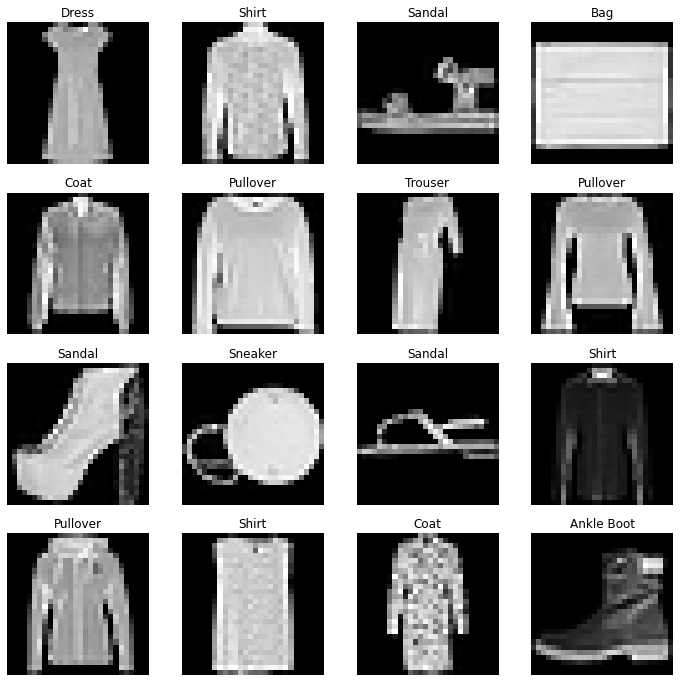

In [ ]:
import matplotlib.pyplot as plt

labels_map = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

figure = plt.figure(figsize = (12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
  image = images[i].squeeze() #이미지
  label_idx = predicted[i].item() #라벨
  label = labels_map[label_idx] #라벨명 테이블에서 해당하는 라벨 가져오기

  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(image, cmap = 'gray') #그림 그리기

plt.show()

In [ ]:
corrected = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    corrected += (predicted == labels).sum().item()

print(100 * corrected / total)

82.44
